In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
from itertools import repeat
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import re

from hannah.nas.search_space.space import Space, Cell
from hannah.nas.search_space.operator import *
from hannah.nas.search_space.utils import get_random_cfg_vec, vec_to_knob, draw_pretty_nodes
from hannah.nas.search_space.model import Model
from hannah.nas.search_space.connectivity_constrainer import DARTSCell, DARTSGraph

In [14]:
num_cells = 3

num_nodes = 4
num_input = 2
num_output = 1

redux_cells = [1]

IN_EDGES = num_nodes

def double_channel(x):
    return 2*x

def double_channel_mult(x):
    return 2*x*IN_EDGES

def same_channel(x):
    return x

def same_channel_mult(x):
    return x*IN_EDGES

preprocess_cell = DARTSCell(num_inputs=0, num_nodes=0, num_outputs=1)
cells = list(repeat(DARTSCell(), num_cells))
darts_graph = DARTSGraph([preprocess_cell] + cells)

dw_conv = DepthwiseSeparableConvolution(same_channel, kernel_size=[3, 5],  dilation=[1], padding='same')
dw_conv_redux = DepthwiseSeparableConvolution(double_channel, kernel_size=[3, 5], dilation=[2], padding='half', stride=2)

identity = Operator()


factorized_reduce_normal = FactorizedReduce(stride=1, out_channels=same_channel)
factorized_reduce_redux = FactorizedReduce(stride=2, out_channels=double_channel)


pool = Pooling(mode=['max', 'avg'], kernel_size=3, stride=1, padding='same')
pool_reduce = Pooling(mode=['max', 'avg'], kernel_size=3, stride=2, padding='half')
zero = Zero()
act = Activation('relu')
add = Combine('add')
add_1x1 = Combine('add')
concat = Combine('concat')
choice = Choice([dw_conv, factorized_reduce_normal, zero])
choice_redux = Choice([dw_conv_redux, factorized_reduce_redux, zero])





factorized_reduce_redux_skip = FactorizedReduce(stride=2, out_channels=double_channel_mult)
factorized_reduce_normal_skip = FactorizedReduce(stride=1, out_channels=same_channel_mult)

operator_node = Cell([choice])
input_node = Cell([identity])
add_node = Cell([add_1x1])
output_node = Cell([concat])
fact_red_redux = Cell([factorized_reduce_redux_skip])
fact_red_normal = Cell([factorized_reduce_normal_skip])

operator_redux = Cell([choice_redux])


ct = 0
cell_dict = {}
types = nx.get_node_attributes(darts_graph.m_arch, 'type')
cells = nx.get_node_attributes(darts_graph.m_arch, 'cell')
label_dict = {}
for node in darts_graph.m_arch:
    
    if types[node] == 'op' and isinstance(cells[node], tuple) and cells[node][0] == cells[node][1] and types[node[0]] == 'input' and cells[node][0] in redux_cells:
        cell_dict[node] = operator_redux.new()
        label_dict[node] = 'red'
    elif types[node] == 'op' and cells[node][0] != cells[node][1]:
        if cells[node[0] + 1] in redux_cells and cells[node][0] + 1 != cells[node][1]:
            cell_dict[node] = fact_red_redux.new()
            label_dict[node] = 'fr r'
        elif cells[node[0] + 1] not in redux_cells and cells[node][0] + 1 != cells[node][1]:
            cell_dict[node] = fact_red_normal.new()
            label_dict[node] = 'fr n'
        else:
            cell_dict[node] = input_node.new()
            label_dict[node] = 'id'
    elif types[node] == 'op':
        cell_dict[node] = operator_node.new()
        label_dict[node] = "norm"
    elif types[node] == 'input':
        cell_dict[node] = input_node.new()
    elif types[node] == 'sum':
        cell_dict[node] = add_node.new()
    elif types[node] == 'cat':
        cell_dict[node] = output_node.new()

space = Space(cell_dict, darts_graph)


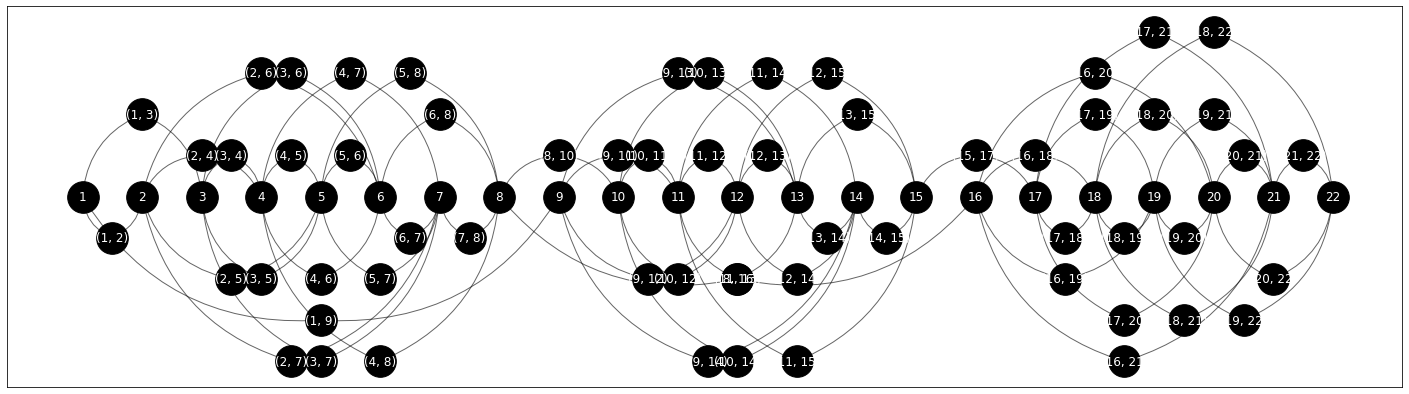

In [15]:
labels = nx.get_node_attributes(darts_graph.m_arch, 'type')
fig = draw_pretty_nodes(darts_graph.m_arch, labels=None)

In [16]:
knobs = space.get_knobs()
vec = get_random_cfg_vec(knobs=knobs)
cfg = vec_to_knob(vec, knobs)
instance = space.get(cfg)

In [17]:
input_shape = np.array([1, 12, 32, 32])
model = Model(instance, input_shape)

In [18]:
input = torch.ones(tuple(input_shape))
# print(input.shape)
output = model(input)
print(output.shape)

stack expects each tensor to be equal size, but got [1, 24, 16, 16] at entry 0 and [1, 12, 32, 32] at entry 1
add_6_0


UnboundLocalError: local variable 'out' referenced before assignment

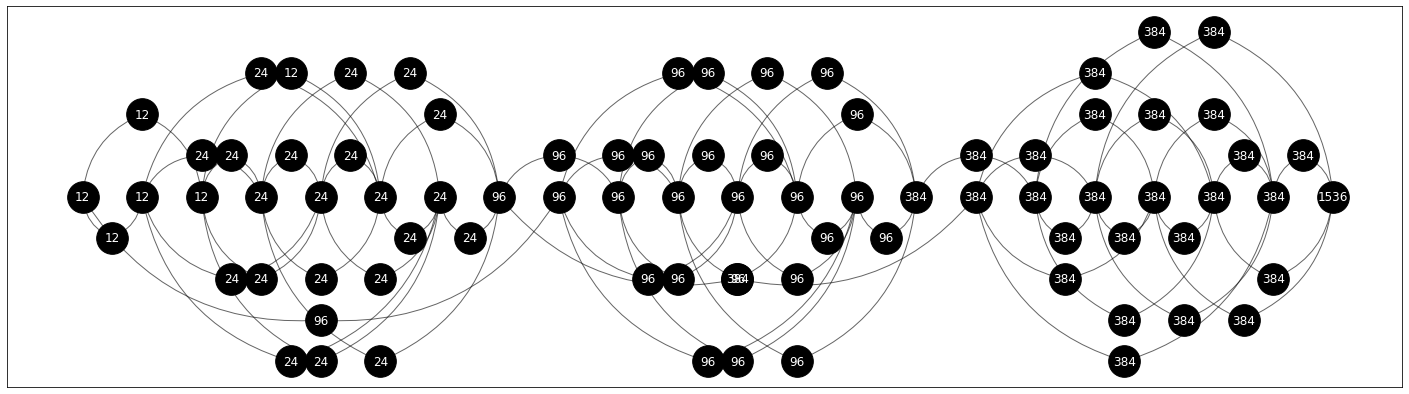

In [19]:
shapes = nx.get_node_attributes(instance, 'output_shape')
ids = nx.get_node_attributes(instance, 'id')
names = {k: v.split('_')[-2] for k, v in ids.items()}
int_names = {}
output_shapes = {}

for k, n in names.items():
    s = re.findall('[0-9]+', n)
    s = [int(i) for i in s]
    s = tuple(s) if len(s) > 1 else s[0]
    output_shapes[s] = shapes[k][1]
        
fig = draw_pretty_nodes(darts_graph.m_arch, labels=output_shapes)